In [7]:
#Boiler plate imports
import pandas as pd
import sys
from time import time
import matplotlib.pyplot as plt
import os

#Stats
from sklearn.metrics import roc_curve, auc, precision_recall_curve

#SBND imports
s0 = time()
sys.path.append('/exp/sbnd/app/users/brindenc/analyze_sbnd/pyana')
from sbnd.general import utils
from sbnd.cafclasses.slice import CAFSlice
from sbnd.cafclasses.pfp import PFP

#Constants
from sbnd.numu.numu_constants import *
from sbnd.prism import PRISM_BINS
from sbnd.constants import *
from sbnd.volume import FV,AV

#Plotters
from sbnd.plotlibrary import makeplot
from sbnd.general import plotters

s1 = time()
print(f'SBND imports: {s1-s0:.2f} s')

%load_ext autoreload
%autoreload 2

SBND imports: 0.00 s
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load DAta

In [84]:
#Constants/variables
CUT_MODE = 'roc'
DATA_DIR  = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_78_04_wc_pandora'
#DATA_DIR = '/exp/sbnd/data/users/brindenc/ML/test_fcl/debug_trackid/v4'
#FNAME = 'single_processed.df'
#FNAME = 'single_cut_cosmics_processed.df'
#HDR_FNAME = 'single.df'
FNAME = f'all_processed_{CUT_MODE}.df'
HDR_FNAME = 'all.df'
#FNAME = 'test_processed.df'
#HDR_FNAME = 'test.df'
NOM_POT = 0.6e20 # stats for first run
LABEL = 'SBND Work in Progress\n0.6e20 POT'
PLOT_DIR = f'Plots/reco_{plotters.day}_{CUT_MODE}/roc'
SAVE_PLOT = True

In [85]:
os.makedirs(f'{DATA_DIR}/roc_scores',exist_ok=True)

In [86]:
#Get data and POT
pfp = PFP.load(f'{DATA_DIR}/{FNAME}','pfp'
               ,prism_bins=PRISM_BINS
               ,momentum_bins=MOMENTUM_BINS
               ,costheta_bins=COSTHETA_BINS
               ,pot=NOM_POT)
slc = CAFSlice.load(f'{DATA_DIR}/{FNAME}','slice'
                    ,prism_bins=PRISM_BINS
                    ,pot=NOM_POT)
hdr = pd.read_hdf(f'{DATA_DIR}/{HDR_FNAME}',key='hdr')
SAMPLE_POT = hdr.pot.sum()

#Scale to nominal POT
print(f'--scaled by {NOM_POT/SAMPLE_POT:.2f}')
pfp.scale_to_pot(NOM_POT,SAMPLE_POT)
slc.scale_to_pot(NOM_POT,SAMPLE_POT)

--scaled by 6.93
--scaling to POT: 8.65e+18 -> 6.00e+19
--scaling to POT: 8.65e+18 -> 6.00e+19


In [87]:
CUTS = ['cosmic','fv','trk','has_muon']
pur,eff,f1 = slc.get_pur_eff_f1(['cosmic','fv','trk','has_muon'])
pur,eff,f1

(array([0.21441237, 0.60952486, 0.77733428, 0.82415334, 0.87864321]),
 array([1.        , 0.7441164 , 0.63218302, 0.59152916, 0.50852108]),
 array([1.        , 0.67012946, 0.69728486, 0.68872891, 0.64420429]))

## 2. Cuts

In [88]:
def make_roc_plot(y,scores,ax=None,fig=None,weights=None,pos_label=0,label=LABEL,title='ROC Curve',show_j=False,show_f1=False):
    """
    Make a ROC plot with Youden's J statistic
    """
    fpr, tpr, thresholds = roc_curve(y, scores, pos_label=pos_label, sample_weight=weights)
    j = tpr - fpr # Youden's J statistic
    f1 = 2 * (tpr * (1-fpr)) / (tpr + (1-fpr)) #f1 score
    j_best_score = abs(thresholds[j.argmax()]) #use abs since scores going low to high doesn't work well
    f1_best_score = abs(thresholds[f1.argmax()]) #use abs since scores going low to high doesn't work well
    roc_auc = auc(fpr, tpr)

    #Make plot
    if fig is None and ax is None:
        fig,ax = plt.subplots()
    elif fig is None:
        fig = ax.get_figure()
    elif ax is None:
        ax = fig.gca()
    ax.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:0.2f})')
    if show_j:
        ax.plot(fpr, j, lw=2, label=f'Youden\'s J (Max = {j_best_score:0.2f})')
    if show_f1:
        ax.plot(fpr, f1, lw=2, label=f'F1 (Max = {f1_best_score:0.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('Signal Efficiency')
    ax.set_ylabel('Background Rejection')
    ax.set_title(title)
    #ax.set_title(f'{title} (Best = {j_best_score:0.2f})')
    ax.legend()
    return fig,ax

In [89]:
def make_pur_eff_plot(y,scores,pos_label=0,title='Purity vs Efficiency',fig=None,ax=None,weights=None,show_f1=False,**kwargs):
    pur,eff,thresholds = precision_recall_curve(y,scores,pos_label=pos_label,sample_weight=weights)
    pur_auc = auc(eff,pur)
    f1 = 2 * (pur * eff) / (pur + eff)
    best_score = thresholds[f1.argmax()]
    if fig is None and ax is None:
        fig,ax = plt.subplots()
    elif fig is None:
        fig = ax.get_figure()
    elif ax is None:
        ax = fig.gca()
    ax.plot(eff,pur,label=f'Eff & Pur (AUC = {pur_auc:.2f})',**kwargs)
    if show_f1:
        ax.plot(eff,f1,label=f'f1 (Max = {best_score:.2f})',**kwargs)
    ax.set_xlabel('Efficiency')
    ax.set_ylabel('Purity')
    ax.set_title(title)
    ax.legend()
    return fig,ax
        
    

### 2.1. Cosmics

/tmp/ipykernel_11302/2992099003.py:4: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * (pur * eff) / (pur + eff)


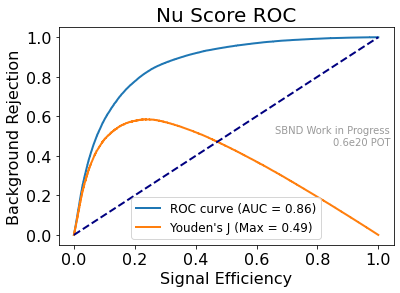

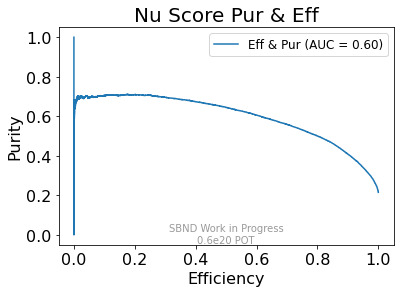

In [90]:
#Nu score ROC
weights = slc.data.genweight
scores = slc.data.nu_score
y = slc.data.truth.event_type
df = pd.concat([scores,y],axis=1)
#save into data_dir
df.to_csv(f'{DATA_DIR}/roc_scores/{FNAME[:-3]}_nu_score.csv')

#ROC plot
fig,ax = make_roc_plot(y,scores,weights=weights,title='Nu Score ROC',show_j=True)
plotters.set_style(ax)
plotters.add_label(ax, LABEL,where='centerright',color='grey',alpha=0.8)
if SAVE_PLOT:
    plotters.save_plot('nu_score',folder_name=f'{PLOT_DIR}',fig=fig)
    
#Purity vs Efficiency
fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Nu Score Pur & Eff',weights=weights)
plotters.set_style(ax)
plotters.add_label(ax, LABEL,where='bottomcenter',color='grey',alpha=0.8)
if SAVE_PLOT:
    plotters.save_plot('nu_score_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)
#Compare to other dataset

/tmp/ipykernel_11302/2992099003.py:4: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * (pur * eff) / (pur + eff)


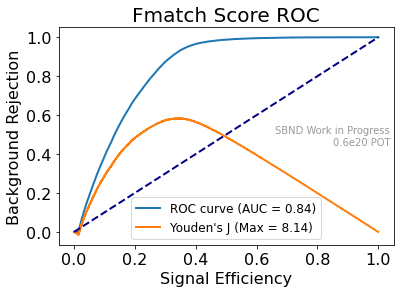

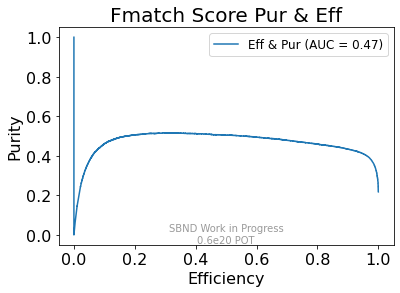

In [91]:
#Fmatch score ROC
scores = -slc.data.fmatch.score
y = slc.data.truth.event_type
weights = slc.data.genweight
df = pd.concat([scores,y],axis=1)
#save into data_dir
df.to_csv(f'{DATA_DIR}/roc_scores/{FNAME[:-3]}_fmatch_score.csv')

#Roc plot
fig,ax = make_roc_plot(y,scores,weights=weights,title='Fmatch Score ROC',show_j=True)
plotters.add_label(ax, LABEL,where='centerright',color='grey',alpha=0.8)
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('fmatch_score',folder_name=f'{PLOT_DIR}',fig=fig)

#Purity vs Efficiency
fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Fmatch Score Pur & Eff',weights=weights)
plotters.set_style(ax)
plotters.add_label(ax, LABEL,where='bottomcenter',color='grey',alpha=0.8)
if SAVE_PLOT:
    plotters.save_plot('fmatch_score_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)

### 2.2 FV
There's no good way to do this yet ..

In [92]:
_slc = slc.copy()
_slc.apply_cut('cosmic')


### 2.3 Track

In [93]:
_slc = slc.copy()
#apply cuts
_slc.apply_cut('cosmic')
_slc.apply_cut('fv')

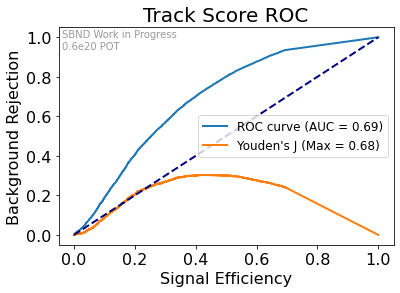

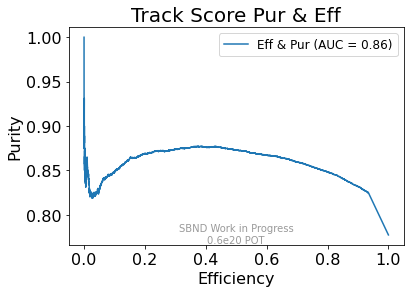

In [94]:
#Track score ROC
scores = _slc.data.best_trk_score
y = _slc.data.truth.event_type
weights = _slc.data.genweight
df = pd.concat([scores,y],axis=1)
#save into data_dir
df.to_csv(f'{DATA_DIR}/roc_scores/{FNAME[:-3]}_track_score.csv')

#MAke ROC plot
fig,ax = make_roc_plot(y,scores,weights=weights,title='Track Score ROC',show_f1=False,show_j=True)
plotters.add_label(ax, LABEL,where='topleft',color='grey',alpha=0.8)
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('track_score',folder_name=f'{PLOT_DIR}',fig=fig)

#Purity vs Efficiency
fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Track Score Pur & Eff',weights=weights)
plotters.set_style(ax)
plotters.add_label(ax, LABEL,where='bottomcenter',color='grey',alpha=0.8)
if SAVE_PLOT:
    plotters.save_plot('track_score_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)
    

### 2.4 Muon

NANs: 41924 , Non NANs: 108120


/tmp/ipykernel_11302/2992099003.py:4: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * (pur * eff) / (pur + eff)


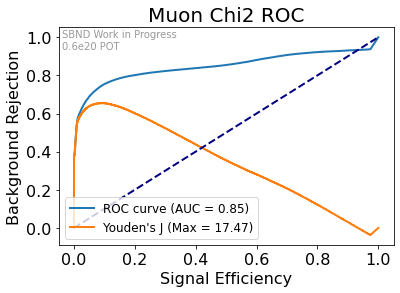

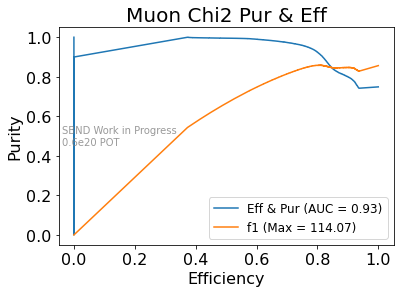

In [95]:
#This roc score has to be on the muons themselves
_pfp = pfp.copy()
_pfp.apply_cut(slc,'cosmic')
_pfp.apply_cut(slc,'fv')
_pfp.apply_cut(slc,'trk')

#Muon chi2 ROC
scores = _pfp.data.trk.chi2pid.I2.chi2_muon
print(f'NANs: {scores.isna().sum()} , Non NANs: {scores.notna().sum()}')
scores[scores.isna()] = 1e2 #fill in nan values to very large value
y = _pfp.data.trk.truth.p.pdg==13
weights = _pfp.data.genweight
df = pd.concat([scores,y],axis=1)
#save into data_dir
df.to_csv(f'{DATA_DIR}/roc_scores/{FNAME[:-3]}_muon_chi2.csv')

#Make ROC
fig,ax = make_roc_plot(y,scores,weights=weights,title='Muon Chi2 ROC',show_j=True)
plotters.add_label(ax, LABEL,where='topleft',color='grey',alpha=0.8)
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('muon_chi2',folder_name=f'{PLOT_DIR}',fig=fig)

#Purity vs Efficiency
fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Muon Chi2 Pur & Eff',show_f1=True,weights=weights)
plotters.set_style(ax)
plotters.add_label(ax, LABEL,where='centerleft',color='grey',alpha=0.8)
if SAVE_PLOT:
    plotters.save_plot('muon_chi2_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)


NANs: 41924 , Non NANs: 108120


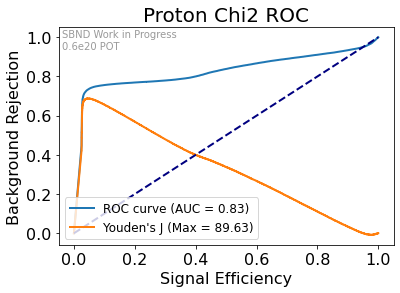

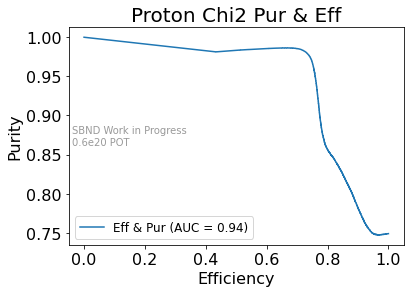

In [96]:
#Proton chi2 ROC
scores = -_pfp.data.trk.chi2pid.I2.chi2_proton
print(f'NANs: {scores.isna().sum()} , Non NANs: {scores.notna().sum()}')
scores[scores.isna()] = 0 #fill in nan values to small value
y = _pfp.data.trk.truth.p.pdg==13 #Still trying to match to muons
weights = _pfp.data.genweight
df = pd.concat([scores,y],axis=1)
#save into data_dir
df.to_csv(f'{DATA_DIR}/roc_scores/{FNAME[:-3]}_proton_chi2.csv')

#Make ROC
fig,ax = make_roc_plot(y,scores,weights=weights,title='Proton Chi2 ROC',show_j=True)
plotters.add_label(ax, LABEL,where='topleft',color='grey',alpha=0.8)
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('proton_chi2',folder_name=f'{PLOT_DIR}',fig=fig)

#Purity vs Efficiency
fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Proton Chi2 Pur & Eff',weights=weights)
plotters.set_style(ax)
plotters.add_label(ax, LABEL,where='centerleft',color='grey',alpha=0.8)
if SAVE_PLOT:
    plotters.save_plot('proton_chi2_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)


NANs: 41924 , Non NANs: 108120


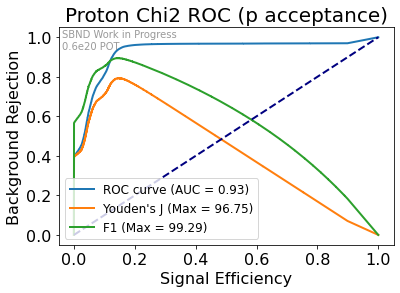

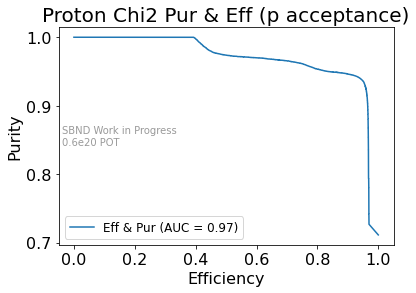

In [97]:
#Proton chi2 ROC
scores = _pfp.data.trk.chi2pid.I2.chi2_proton
print(f'NANs: {scores.isna().sum()} , Non NANs: {scores.notna().sum()}')
scores[scores.isna()] = 1e4 #fill in nan values to small value
y = _pfp.data.trk.truth.p.pdg==2212 #Still trying to match to muons
weights = _pfp.data.genweight
df = pd.concat([scores,y],axis=1)
#save into data_dir
df.to_csv(f'{DATA_DIR}/roc_scores/{FNAME[:-3]}_proton_proton_chi2.csv')

#Make ROC
fig,ax = make_roc_plot(y,scores,weights=weights,title='Proton Chi2 ROC (p acceptance)',show_f1=True,show_j=True)
plotters.add_label(ax, LABEL,where='topleft',color='grey',alpha=0.8)
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('proton_proton_chi2',folder_name=f'{PLOT_DIR}',fig=fig)
    
#Purity vs Efficiency
fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Proton Chi2 Pur & Eff (p acceptance)',weights=weights)
plotters.set_style(ax)
plotters.add_label(ax, LABEL,where='centerleft',color='grey',alpha=0.8)
if SAVE_PLOT:
    plotters.save_plot('proton_proton_chi2_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)

NANs: 41924 , Non NANs: 108120


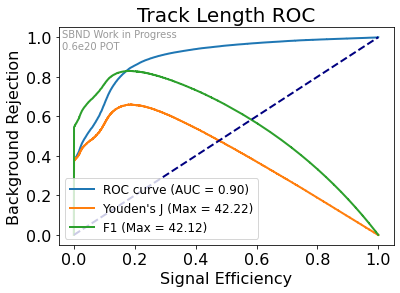

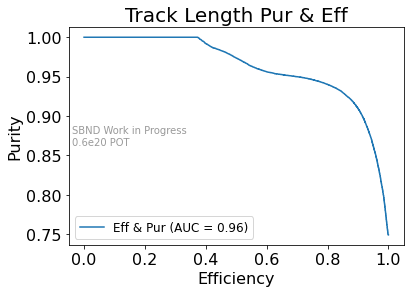

In [98]:
# Track length ROC
scores = -_pfp.data.trk.len
print(f'NANs: {scores.isna().sum()} , Non NANs: {scores.notna().sum()}')
scores[scores.isna()] = 0 #fill in nan values to small value
y = _pfp.data.trk.truth.p.pdg==13
weights = _pfp.data.genweight
df = pd.concat([scores,y],axis=1)
#save into data_dir
df.to_csv(f'{DATA_DIR}/roc_scores/{FNAME[:-3]}_track_len.csv')

#Make ROC
fig,ax = make_roc_plot(y,scores,weights=weights,title='Track Length ROC',show_f1=True,show_j=True)
plotters.add_label(ax, LABEL,where='topleft',color='grey',alpha=0.8)
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('track_len',folder_name=f'{PLOT_DIR}',fig=fig)

#Purity vs Efficiency
fig,ax = make_pur_eff_plot(y,scores,pos_label=0,title='Track Length Pur & Eff',weights=weights)
plotters.set_style(ax)
plotters.add_label(ax, LABEL,where='centerleft',color='grey',alpha=0.8)
if SAVE_PLOT:
    plotters.save_plot('track_len_pur_eff',folder_name=f'{PLOT_DIR}',fig=fig)
